In [1]:
import os
import sys
sys.path.append('..')

import geopandas as gpd
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from utils import move_to, load_model, torch_load_cpu, get_inner_model

import random
import time
import matplotlib.pyplot as plt

from problems.MCLP.problem_MCLP import MCLP

from IPython.display import display, HTML

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
gdf = gpd.read_file("../data/houston_pts_update/houston_landscan_pts.shp")
gdf['POINT_X'] = gdf.geometry.x
gdf['POINT_Y'] = gdf.geometry.y
gdf.head(3)

gdf = gdf.to_crs(epsg=32633)  

x_coords = gdf['POINT_X'].to_numpy()
y_coords = gdf['POINT_Y'].to_numpy()

### Helpers

In [3]:
def normalization(x, y):
    max_x, max_y = np.max(x), np.max(y)
    min_x, min_y = np.min(x), np.min(y)
    S_x = (max_x - min_x)
    S_y = (max_y - min_y)
    S = max(S_x, S_y)
    new_x, new_y = (x - min_x) / S, (y - min_y) / S
    return new_x, new_y, S

def reverse_normalization(new_x, new_y, S, min_x, min_y):
    x = new_x * S + min_x
    y = new_y * S + min_y
    return x, y

def select_and_reverse_normalize(cls, solution_idxs, S, min_x, min_y):
    selected_points = cls[solution_idxs]
    
    new_x, new_y = selected_points[:, 0], selected_points[:, 1]
    original_x, original_y = reverse_normalization(new_x, new_y, S, min_x, min_y)
    original_points = np.vstack((original_x, original_y)).T
    
    return original_points

def save_to_csv(result, file_name):
    df = pd.DataFrame(result, columns=['x', 'y'])
    df.to_csv(file_name, index=False)

def scale_demand_vals(demand_vals, new_min=1, new_max=10):
    min_val = demand_vals.min()
    max_val = demand_vals.max()
    if max_val == min_val:
        return np.full_like(demand_vals, new_min)  

    scaled_vals = new_min + (demand_vals - min_val) * (new_max - new_min) / (max_val - min_val)   
    return scaled_vals

def plot_points_only(demand_points, demand_vals):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    
def plot_points_demands_with_grid(demand_points, demand_vals, candidate_points, grid_size):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    
def plot_points_vals_cov_with_grid(demand_points, demand_vals, candidate_points, grid_size, selected_idxes, radius):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')
    
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()
    
def plot_points(demand_points, demand_vals, candidate_points, selected_idxes, radius, title=None):
    """
    Plot the demand points, candidate points (CLS), and selected coverage circles.

    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param selected_idxes: List of indexes corresponding to the selected candidate points
    :param radius: Radius for the coverage circles
    :param demand_vals: Array of demand values corresponding to each demand point
    """
    if len(demand_points) != len(demand_vals):
        raise ValueError("The length of demand_points and demand_vals must be the same.")

    plt.figure(figsize=(10, 8))

    # Normalize demand values for color mapping
    norm = plt.Normalize(vmin=min(demand_vals), vmax=max(demand_vals))
    cmap = plt.cm.Blues

    # Plot demand points with color intensity based on demand values
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c=demand_vals, cmap=cmap, norm=norm, label='Demand Points', s=10)

    # Plot candidate points
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')

    # Plot selected points and their coverage circles
    for idx in selected_idxes:
        point = candidate_points[idx]
        circle = plt.Circle((point[0], point[1]), radius, color='green', fill=False, linestyle='--',
                            label='Coverage Area' if idx == selected_idxes[0] else "")
        plt.gca().add_patch(circle)
        plt.scatter(point[0], point[1], c='green', label='Selected Points' if idx == selected_idxes[0] else "",
                    s=30, marker='o')

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    if title:
        plt.title(title)
    else:
        plt.title(
            f"{len(demand_points)} demand units - {len(candidate_points)} CLS - {len(selected_idxes)} selected (r={radius})"
        )
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')
    plt.show()
    
def get_best(sequences, cost, ids=None, batch_size=None):
    """
    Ids contains [0, 0, 0, 1, 1, 2, ..., n, n, n] if 3 solutions found for 0th instance, 2 for 1st, etc
    :param sequences:
    :param lengths:
    :param ids:
    :return: list with n sequences and list with n lengths of solutions
    """
    if ids is None:
        idx = cost.argmin()
        return sequences[idx:idx+1, ...], cost[idx:idx+1, ...]

    splits = np.hstack([0, np.where(ids[:-1] != ids[1:])[0] + 1])
    mincosts = np.minimum.reduceat(cost, splits)

    group_lengths = np.diff(np.hstack([splits, len(ids)]))
    all_argmin = np.flatnonzero(np.repeat(mincosts, group_lengths) == cost)
    result = np.full(len(group_lengths) if batch_size is None else batch_size, -1, dtype=int)

    result[ids[all_argmin[::-1]]] = all_argmin[::-1]

    return [sequences[i] if i >= 0 else None for i in result], [cost[i] if i >= 0 else math.inf for i in result]

### Filtering the generated CLS

In [4]:
# Function to calculate covered demand points for a given candidate
def calculate_covered(demand_points, candidate, radius):
    """
    Calculate which demand points are covered by the given candidate point.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate: Candidate point coordinates (x, y)
    :param radius: Coverage radius
    :return: Array of covered demand points
    """
    distances = np.linalg.norm(demand_points - candidate, axis=1)
    return demand_points[distances <= radius]


# Function to filter candidate points that do not cover any demand points or are out of bounds
def filter_candidate_points(demand_points, candidate_points, coverage_radius, bounds=(0, 1)):
    """
    Filter out candidate points that do not cover any demand points or are out of bounds.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param bounds: A tuple representing the (min, max) bounds for both x and y coordinates
    :return: Filtered array of candidate points that cover at least one demand point and are within bounds
    """
    filtered_candidates = []
    
    min_bound, max_bound = bounds  # Unpack bounds
    
    for candidate in candidate_points:
        # Check if the candidate is within the specified bounds
        if np.all(candidate >= min_bound) and np.all(candidate <= max_bound):
            covered_points = calculate_covered(demand_points, candidate, coverage_radius)
            if len(covered_points) > 0:  # Keep candidates that cover at least one demand point
                filtered_candidates.append(candidate)
    
    return np.array(filtered_candidates)

# Function to calculate discounted coverage for each candidate
def calculate_discounted_coverage(demand_points, candidate_points, coverage_radius):
    """
    Calculate the discounted coverage for each candidate, where the contribution of a demand point is shared among 
    all candidates that cover it.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :return: List of tuples (candidate, discounted_coverage)
    """
    # Step 1: Initialize dictionaries to store the coverage of each demand point
    demand_coverage_count = {tuple(dp): 0 for dp in demand_points}  # Tracks how many candidates cover each demand point
    candidate_coverage = {tuple(cp): 0 for cp in candidate_points}  # Tracks the discounted coverage of each candidate
    
    # Step 2: Calculate how many candidates cover each demand point
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            demand_coverage_count[tuple(dp)] += 1  # Increment the count for each demand point
    
    # Step 3: Calculate the discounted coverage for each candidate
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            # Discount the coverage contribution by the number of candidates covering this demand point
            candidate_coverage[tuple(candidate)] += 1 / demand_coverage_count[tuple(dp)]
    
    # Step 4: Convert the dictionary to a list of tuples for sorting
    return [(candidate, candidate_coverage[tuple(candidate)]) for candidate in candidate_points]

# Function to remove the least effective candidate points based on discounted coverage
def remove_least_effective_candidates_with_discount(demand_points, candidate_points, coverage_radius, final_count):
    """
    Remove candidate points that have the least effective discounted coverage until only final_count candidates remain.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param final_count: The number of final candidate points to retain
    :return: Array of remaining candidate points after removing the least effective ones
    """
    # Step 1: Calculate the discounted coverage for each candidate
    candidate_discounted_coverage = calculate_discounted_coverage(demand_points, candidate_points, coverage_radius)
    
    # Step 2: Sort candidates by their discounted coverage in ascending order
    candidate_discounted_coverage.sort(key=lambda x: x[1])  # Sort by discounted coverage (ascending)
    
    # Step 3: Keep the top candidates with the highest discounted coverage, discard the rest
    # Keep only the top 'final_count' candidates
    remaining_candidates = [item[0] for item in candidate_discounted_coverage[-final_count:]]  
    
    return np.array(remaining_candidates)


# Function to calculate discounted coverage with demand values for each candidate
def calculate_discounted_coverage_with_demand(demand_points, demand_vals, candidate_points, coverage_radius):
    """
    Calculate the discounted coverage for each candidate, considering the demand value of each demand point, where the 
    contribution of a demand point is shared among all candidates that cover it.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param demand_vals: Array of demand values corresponding to demand points
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :return: List of tuples (candidate, discounted_coverage)
    """
    # Step 1: Initialize dictionaries to store the coverage of each demand point
    demand_coverage_count = {tuple(dp): 0 for dp in demand_points}  # Tracks how many candidates cover each demand point
    candidate_coverage = {tuple(cp): 0 for cp in candidate_points}  # Tracks the discounted coverage of each candidate
    
    # Step 2: Calculate how many candidates cover each demand point
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            demand_coverage_count[tuple(dp)] += 1  # Increment the count for each demand point
    
    # Step 3: Calculate the discounted coverage for each candidate considering demand values
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            dp_index = np.where(np.all(demand_points == dp, axis=1))[0][0]  # Get the index of the demand point
            demand_value = demand_vals[dp_index]  # Get the demand value for this demand point
            # Discount the coverage contribution by the number of candidates covering this demand point, 
            # weighted by demand value
            candidate_coverage[tuple(candidate)] += demand_value / demand_coverage_count[tuple(dp)]
    
    # Step 4: Convert the dictionary to a list of tuples for sorting
    return [(candidate, candidate_coverage[tuple(candidate)]) for candidate in candidate_points]

# Function to remove the least effective candidate points based on discounted coverage with demand values
def remove_least_effective_candidates_with_discount_and_demand(demand_points, demand_vals, candidate_points, \
                                                               coverage_radius, final_count):
    """
    Remove candidate points that have the least effective discounted coverage (considering demand values) until only 
    final_count candidates remain.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param demand_vals: Array of demand values corresponding to demand points
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param final_count: The number of final candidate points to retain
    :return: Array of remaining candidate points after removing the least effective ones
    """
    # Step 1: Calculate the discounted coverage for each candidate, considering demand values
    candidate_discounted_coverage = calculate_discounted_coverage_with_demand(demand_points, demand_vals, \
                                                                              candidate_points, coverage_radius)
    
    # Step 2: Sort candidates by their discounted coverage in ascending order
    candidate_discounted_coverage.sort(key=lambda x: x[1])  # Sort by discounted coverage (ascending)
    
    # Step 3: Keep the top candidates with the highest discounted coverage, discard the rest
    remaining_candidates = [item[0] for item in candidate_discounted_coverage[-final_count:]]  
    
    return np.array(remaining_candidates)

def calculate_solution_objective(demand_points, demand_vals, facility_candidate_locations, radius, selected_facility_indexes):
    covered_points = set()  

    for facility_idx in selected_facility_indexes:
        facility = facility_candidate_locations[facility_idx]  

        for i, demand_point in enumerate(demand_points):
            distance = np.linalg.norm(facility - demand_point)  
            if distance <= radius:
                covered_points.add(i)  

    total_demand_covered = sum(demand_vals[i] for i in covered_points)
    # Print the number of covered points
    print(f"Number of covered demand points: {len(covered_points)}")

    return total_demand_covered

def calculate_covered_ratio(obj_val, demand_vals):
    return obj_val / demand_vals.sum()
    

### Greedy Select

In [12]:
def greedy_select(demand_pts, demand_vals, cls, r, p):
    # Calculate the distance matrix (Euclidean distance between facilities and demand points)
    distance = np.sqrt(np.sum((cls[:, np.newaxis, :] - demand_pts[np.newaxis, :, :]) ** 2, axis=-1))
    
    # Initialize variables
    covered_demand = np.zeros(len(demand_pts), dtype=bool)  # Tracks if a demand point is covered
    selected_centers = []  # Stores the indices of selected facilities
    total_covered_demand = 0
    
    # Greedy selection loop
    for _ in range(p):
        max_additional_coverage = 0
        best_candidate = None
        
        # Iterate over all candidate facilities
        for i, facility in enumerate(cls):
            if i in selected_centers:
                continue  # Skip already selected facilities
            
            # Determine coverage for this candidate
            coverage = (distance[i] <= r)  # Boolean array indicating covered demand points
            additional_coverage = np.sum(demand_vals[coverage & ~covered_demand])  # New coverage gain
            
            # Select the facility with the highest additional coverage
            if additional_coverage > max_additional_coverage:
                max_additional_coverage = additional_coverage
                best_candidate = i
        
        # Break if no more improvement is possible
        if best_candidate is None:
            break
        
        # Update state
        selected_centers.append(best_candidate)
        covered_demand |= (distance[best_candidate] <= r)  # Mark newly covered demand points
        total_covered_demand += max_additional_coverage
    
    return selected_centers, total_covered_demand


### Training data generation methods

In [5]:
# demand pts [0, 1]
def gen_random_demand_points(num_points=500):
    demand_X = np.random.rand(num_points)
    demand_Y = np.random.rand(num_points)
    demand_vals = np.random.rand(num_points)  # [0,1]
    demand_points = np.vstack([demand_X, demand_Y]).T
    return demand_points, demand_vals

# facilites pts [0, 1]
def gen_fixed_facilities(num_facilities=1000):
    facilities_X = np.random.rand(num_facilities)
    facilities_Y = np.random.rand(num_facilities)
    facilities = np.vstack([facilities_X, facilities_Y]).T
    return facilities

# random select m from fixed_facilities
def select_random_facilities(fixed_facilities, m):
    selected_indices = np.random.choice(len(fixed_facilities), m, replace=False)
    selected_facilities = fixed_facilities[selected_indices]
    return selected_facilities

# random data
def gen_random_data(num_sample, n_facilities, p, r, demand_points, demand_vals, fixed_facilities):
    random_datasets = []
    for i in range(num_sample):
        random_facilities = select_random_facilities(fixed_facilities, n_facilities)
        random_data = {}
        random_data["users"] = torch.tensor(demand_points).to(torch.float32)  
        random_data["facilities"] = torch.tensor(random_facilities).to(torch.float32)  
        random_data['demand'] = torch.tensor(demand_vals).to(torch.float32)
        random_data["p"] = p
        random_data["r"] = r  
        random_datasets.append(random_data)
        print(f"generate sample {i+1}/{num_sample}")
    return random_datasets

def save_dataset_as_pkl(dataset, filename):
    pd.to_pickle(dataset, filename)
    print(f"data saved to {filename}")

def generate_random_data(num_sample, n_demand_pts, n_facilities, p, r, uses):
    demand_points, demand_vals = gen_random_demand_points(n_demand_pts) 
    fixed_facilities = gen_fixed_facilities(n_facilities * 5)  # 5 times facilities cls
    filename = os.path.join(r".\data", f"mclp_{n_demand_pts}_{n_facilities}_{p}_random_{uses}.pkl")
    dataset = gen_random_data(num_sample, n_facilities, p, r, demand_points, demand_vals, fixed_facilities)
    save_dataset_as_pkl(dataset, filename)
    
def gen_random_data_with_inputs(num_sample, n_facilities, p, r, users, demand, facilities_set):
    random_datasets = []
    for i in range(num_sample):
        # 从facilities_set
        random_facilities = select_random_facilities(facilities_set, n_facilities)
        random_data = {}
        random_data["users"] = torch.tensor(users).to(torch.float32)
        random_data["facilities"] = torch.tensor(random_facilities).to(torch.float32)
        random_data["demand"] = torch.tensor(demand).to(torch.float32)
        random_data["p"] = p
        random_data["r"] = r
        random_datasets.append(random_data)
        if (i + 1) % 1000 == 0:
            print(f"Generated {i+1}/{num_sample} samples")
    
    return random_datasets

def get_random_sample_from_datasets(random_datasets):
    random_sample = random.choice(random_datasets)   
    # return users, demand 和 facilities
    users = random_sample["users"]
    demand = random_sample["demand"]
    facilities = random_sample["facilities"]
    
    return users, demand, facilities

### GBH method for generating CLS

In [6]:
# Round demand points to the nearest grid points
def round_to_grid(demand_points, grid_size):
    """
    Round demand points to the nearest grid center instead of the grid intersection points.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param grid_size: Size of the grid (e.g., sqrt(2) * coverage_radius or user-defined)
    :return: Array of rounded grid points centered in each grid cell
    """
    # Shift the points by half a grid size before rounding to move them to grid centers
    return np.round((demand_points + grid_size / 2) / grid_size) * grid_size - grid_size / 2

# Expand grid points by shifting them in four directions
def expand_grid_points(grid_points, radius, shift_ratio=0.5):
    """
    Expand the grid points by shifting them in four directions: up-left, up-right, down-left, down-right.
    
    :param grid_points: Array of grid point coordinates (x, y)
    :param radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius (default is 1/2)
    :return: Array of expanded candidate points, including the original grid points and the shifted ones
    """
    expanded_points = []
    shifts = [(shift_ratio * radius, shift_ratio * radius), 
              (-shift_ratio * radius, shift_ratio * radius), 
              (shift_ratio * radius, -shift_ratio * radius), 
              (-shift_ratio * radius, -shift_ratio * radius)]
    
    for point in grid_points:
        expanded_points.append(point)  # Add the original grid point
        for shift in shifts:
            expanded_points.append(point + np.array(shift))  # Add the shifted point (original point + shift)
    
    return np.array(expanded_points)


# Generate Candidate Location Set (CLS) using GBH algorithm
def generate_cls(demand_points, coverage_radius, shift_ratio=0.5, grid_size=None):
    """
    Generate the Candidate Location Set (CLS) using the GBH algorithm.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius
    :return: Array of candidate points (CLS)
    """
    
    if grid_size is None:
        grid_size = np.sqrt(2) * coverage_radius  # Default value
        
    rounded_points = round_to_grid(demand_points, grid_size)
    expanded_candidates = expand_grid_points(rounded_points, coverage_radius, shift_ratio)
    
    return expanded_candidates

### Generate dataset for Evaluation

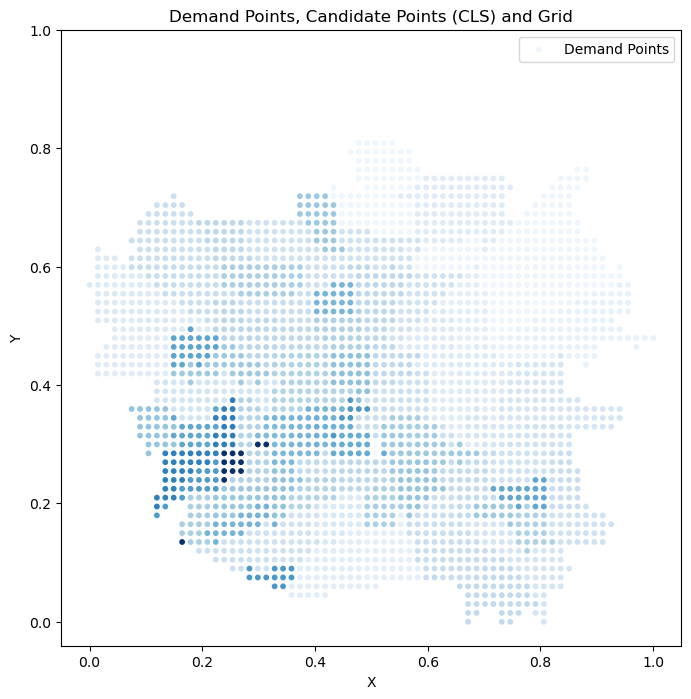

In [7]:
new_x, new_y, S = normalization(x_coords, y_coords)

x_min = np.min(x_coords)
y_min = np.min(y_coords)

gdf['norm_x'] = new_x[:len(gdf)]
gdf['norm_y'] = new_y[:len(gdf)]

demand_pts = gdf[['norm_x', 'norm_y']].to_numpy()
demand_vals = scale_demand_vals(gdf['Pop_Per_Po'].to_numpy())

plot_points_only(demand_pts, demand_vals)

#0.015 is 800 meter
#0.0000187175 is 1 meter
meter_norm = 0.0000187175

Total candidate points: 12325
Unique candidate points: 245
Total candidate points after filtering: 220
Final number of CLS: 100


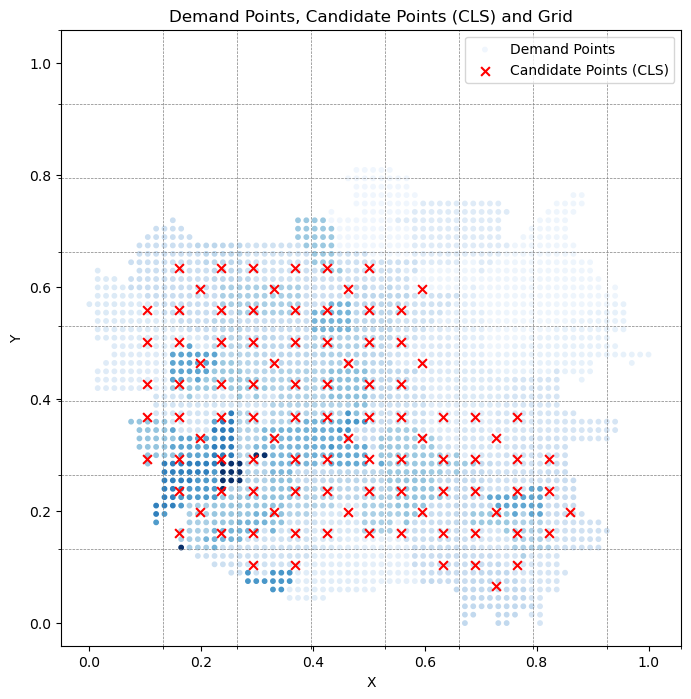

In [8]:
np.random.seed(2024)

#r = 3000 * meter_norm
#n = 200  
#p = 30

r = 5000 * meter_norm 
n = 100
p = 15

## GBH ####################################################################
shift_ratio = 0.4 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * r

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_pts, r, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_pts, unique_candidate_points, r, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
cls = remove_least_effective_candidates_with_discount_and_demand(demand_pts, demand_vals, filtered_candidate_points, r, n)
print(f"Final number of CLS: {len(cls)}")

plot_points_demands_with_grid(demand_pts, demand_vals, cls, grid_size)

### Generate data (for training only, can skip when evaluating model)

In [ ]:
num_sample= 128000
uses = 'train'

filename = os.path.join(r"..\data", f"mclp_{len(demand_pts)}_{n}_{p}_random_{uses}.pkl")
dataset = gen_random_data_with_inputs(num_sample, n, p, r, demand_pts, demand_vals, filtered_candidate_points)

#users, demand, facilities = get_random_sample_from_datasets(dataset)
#plot_points_demands_with_grid(users, demand, facilities, grid_size)

save_dataset_as_pkl(dataset, filename)

### Eval model 100 - 15 - 5k

In [179]:
n_users = len(demand_pts)
n_facilities = n

dataset = MCLP.make_dataset(None, n_users, n_facilities, 1, 0, p, r, None)
dataset.data[0]['users'] = torch.FloatTensor(demand_pts)
dataset.data[0]['demand'] = torch.FloatTensor(demand_vals)
dataset.data[0]['facilities'] = torch.FloatTensor(cls)

dataloader = DataLoader(dataset, batch_size=1)

# get the first batch
batch = next(iter(dataloader))
batch = move_to(batch, device)

model_path = '../outputs/MCLP/hou_test_2465_100_15_20241012T180740/epoch-120.pt'  # Adjust this path to your saved model\n",
model, opts = load_model(model_path)  # load_model returns the model and options used during training\n",

  [*] Loading model from ../outputs/MCLP/hou_test_2465_100_15_20241012T180740/epoch-120.pt


In [221]:
start = time.time()
results = []

num_sample = 1
opts['eval_batch_size'] = 1
opts['max_calc_batch_size'] = 1280000

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("sampling")
opts['decode_strategy'] = 'sampling'
width = 1280 if opts['decode_strategy'] == 'sampling' else 0

with torch.no_grad():
    if opts['decode_strategy'] in ('sampling', 'greedy'):
        if opts['decode_strategy'] == 'greedy':
            assert width == 0, "Do not set width when using greedy"
            assert opts["eval_batch_size"] <= opts["max_calc_batch_size"], \
                "eval_batch_size should be smaller than calc batch size"
            batch_rep = 1
            iter_rep = 1
        elif width * opts["eval_batch_size"] > opts["max_calc_batch_size"]:
            assert opts["eval_batch_size"] == 1
            assert width % opts["max_calc_batch_size"] == 0
            batch_rep = opts["max_calc_batch_size"]
            iter_rep = width // opts["max_calc_batch_size"]
        else:
            batch_rep = width
            iter_rep = 1
        assert batch_rep > 0
        
        # sampling
        sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
        batch_size = len(costs)
        ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)

        if sequences is None:
            sequences = [None] * batch_size
            costs = [math.inf] * batch_size
        else:
            sequences, costs = get_best(
                sequences.cpu().numpy(), costs.cpu().numpy(),
                ids.cpu().numpy() if ids is not None else None,
                batch_size
            )
        duration = time.time() - start
        for seq, cost in zip(sequences, costs):
            seq = seq.tolist()
            results.append((cost, seq, duration))
            
# output
costs, tours, durations = zip(*results)
print(f"The objective is: {-costs[0]}")
print(tours[0])
end = time.time() - start
print(f"The running time of DRL is: {end}")

The objective is: 5476.525390625
[88, 14, 92, 39, 22, 45, 37, 68, 80, 4, 51, 1, 56, 52, 93]
The running time of DRL is: 0.05220317840576172


Number of covered demand points: 1607
5759.334007710814
The population covered is: 0.7471194708026554


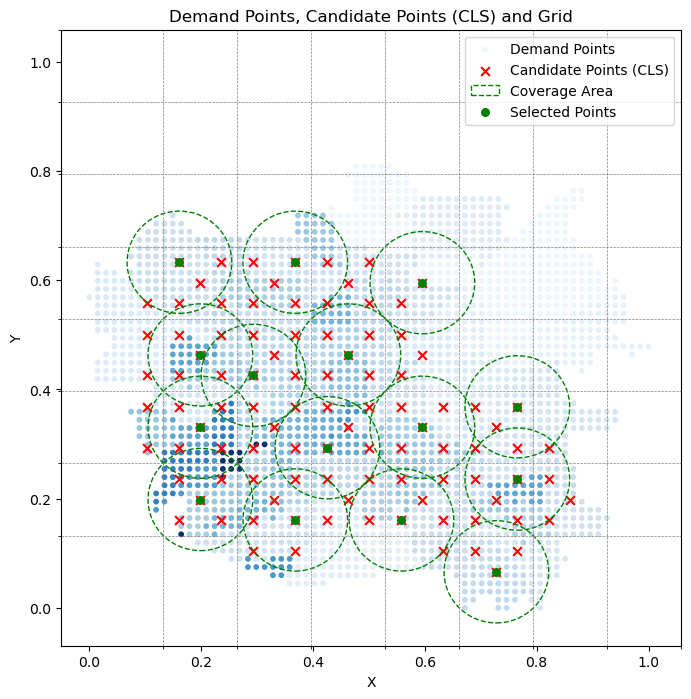

In [206]:
obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, tours[0])
print(obj_val)

ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points_vals_cov_with_grid(demand_pts, demand_vals, cls, grid_size, tours[0], r)


In [207]:
selected_facilities = select_and_reverse_normalize(cls, tours[0], S, x_min, y_min)
selected_facilities

file_name = "../data/deepgridmclp_result_points_5k_15.csv"
save_to_csv(selected_facilities, file_name)

### Greedy Select 100 - 15 - 5k

The running time of Greedy Select is: 0.014752864837646484
Greedy solution centers: [98, 91, 78, 70, 61, 53, 36, 41, 15, 33, 1, 0, 4, 32, 8]
Objective value for greedy solution: 5565.77855546658


C:\Users\yzhon\AppData\Local\Temp\ipykernel_76044\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


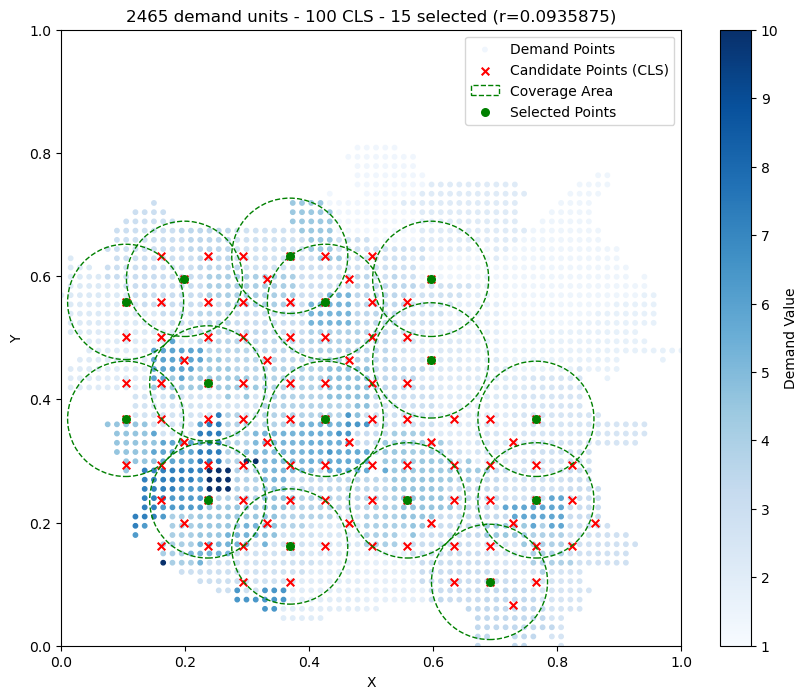

In [23]:
start = time.time()
greedy_solution, greedy_obj_val = greedy_select(demand_pts, demand_vals, cls, r, p)
end = time.time() - start
print(f"The running time of Greedy Select is: {end}")
print(f"Greedy solution centers: {greedy_solution}")
print(f"Objective value for greedy solution: {greedy_obj_val}")

# Optionally plot or compare results with the genetic algorithm solution
plot_points(demand_pts, demand_vals, cls, greedy_solution, r)

### GA 100 - 15 - 5k

Current top solution: [21, 73, 70, 14, 34, 81, 39, 84, 92, 28, 83, 1, 94, 45, 20] f=2507

Final top solution: [94, 32, 64, 35, 71, 96, 21, 93, 50, 22, 30, 48, 80, 41, 26] f=2161
Time: 00:00:0.6160
Number of covered demand points: 1530
5547.382545871994
The population covered is: 0.7196244403368308


C:\Users\yzhon\AppData\Local\Temp\ipykernel_76044\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


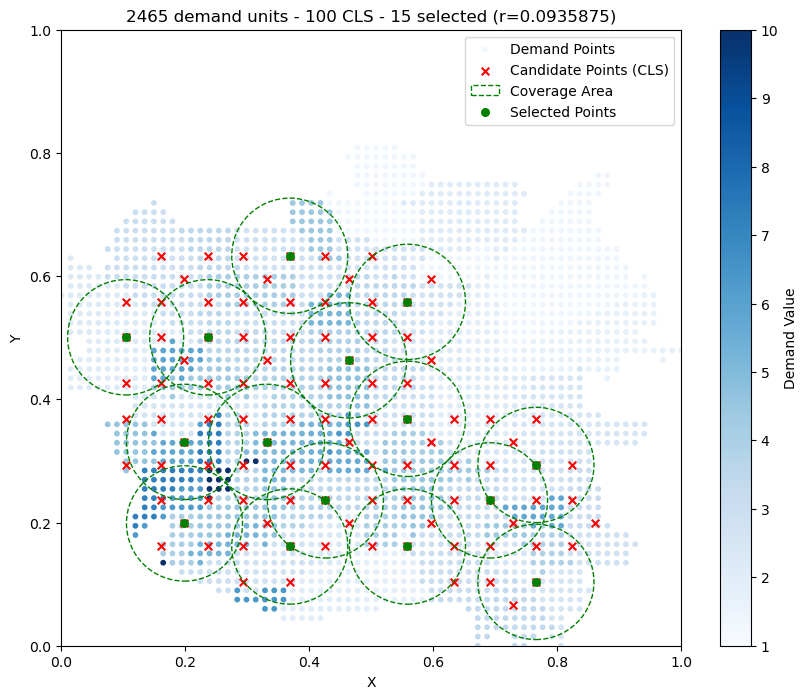

In [9]:
from algorithms.GA import GeneticAlgorithm

# Calculate the distance matrix (Euclidean distance between facilities and demand points)
distance = np.sqrt(np.sum((cls[:, np.newaxis, :] - demand_pts[np.newaxis, :, :]) ** 2, axis=-1))

# Instantiate the genetic algorithm with the necessary parameters
genetic = GeneticAlgorithm(len(demand_pts), len(cls), p, distance, r, demand_vals)

# Run the optimization process
genetic.optimize()

# Get the result (selected centers and the objective value)
obj = np.sum(demand_vals) - genetic.top_chromosome.fitness.item()  # Ensure fitness is a scalar
ga_solution = genetic.top_chromosome.content

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, ga_solution)
print(obj_val)
ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points(demand_pts, demand_vals, cls, ga_solution, r)

In [227]:
ga_selected_facilities = select_and_reverse_normalize(cls, ga_solution, S, x_min, y_min)

ga_file_name = "../data/ga_result_points_5k_15.csv"
save_to_csv(ga_selected_facilities, ga_file_name)

## CPLEX solver 100 - 15 - 5k

In [41]:
from docplex.mp.model import Model

def solve_mclp_cplex(demand_pts, demand_vals, facility_candidate_locations, radius, max_num_selection):
    """
    Solves the Maximal Covering Location Problem using CPLEX.
    """
    num_demand_pts = len(demand_pts)
    num_facilities = len(facility_candidate_locations)
    
    # Create a CPLEX model
    mdl = Model(name="MCLP")

    # Decision variables
    x = mdl.binary_var_list(num_facilities, name="x")  # Facility selection variables
    y = mdl.binary_var_list(num_demand_pts, name="y")  # Demand point coverage variables

    # Calculate coverage: which facilities can cover which demand points
    coverage = []
    for i, demand_pt in enumerate(demand_pts):
        facilities_covering_i = []
        for j, facility in enumerate(facility_candidate_locations):
            # Calculate Euclidean distance between demand point and facility
            if np.linalg.norm(np.array(facility) - np.array(demand_pt)) <= radius:
                facilities_covering_i.append(j)
        coverage.append(facilities_covering_i)
    
    # Objective: maximize the total demand covered
    mdl.maximize(mdl.sum(demand_vals[i].item() * y[i] for i in range(num_demand_pts)))

    # Constraints
    # Each demand point i can only be covered if at least one facility that covers it is selected
    for i in range(num_demand_pts):
        mdl.add_constraint(y[i] <= mdl.sum(x[j] for j in coverage[i]))

    # At most max_num_selection facilities can be selected
    mdl.add_constraint(mdl.sum(x[j] for j in range(num_facilities)) <= max_num_selection)

    # Solve the model
    solution = mdl.solve(log_output=True)
    
    if solution:
        print("Objective Value (Total Demand Covered):", solution.objective_value)
        selected_facilities = [j for j in range(num_facilities) if x[j].solution_value > 0.5]
        print("Selected facility indexes:", selected_facilities)
        return selected_facilities
    else:
        print("No solution found.")
        return None

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.08 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1581 rows and 408 columns.
Aggregator did 18 substitutions.
Reduced MIP has 867 rows, 966 columns, and 6721 nonzeros.
Reduced MIP has 966 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (7.60 ticks)
Probing time = 0.00 sec. (0.36 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 867 rows, 966 columns, and 6721 nonzeros.
Reduced MIP has 966 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.92 ticks)
Probing time = 0.00 sec. (0.36 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.05 sec. (70.12 ticks)

        Nodes                                         Cuts/
   Node  Le

C:\Users\yzhon\AppData\Local\Temp\ipykernel_38892\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


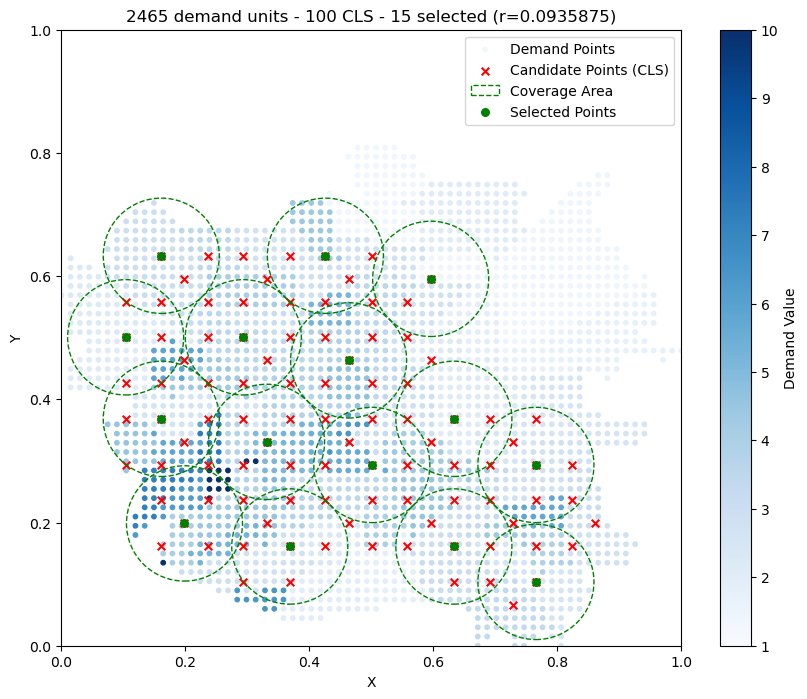

In [229]:
# Solve the problem using the genetic algorithm
cplex_solution = solve_mclp_cplex(demand_pts, demand_vals, cls, r, p)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, cplex_solution)
print(obj_val)

ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points(demand_pts, demand_vals, cls, cplex_solution, r)

In [230]:
cplex_selected_facilities = select_and_reverse_normalize(cls, cplex_solution, S, x_min, y_min)

cplex_file_name = "../data/cplex_result_points_5k_15.csv"
save_to_csv(cplex_selected_facilities, cplex_file_name)

## DeepGridMCLP 200 - 30 - 3k 

Total candidate points: 12325
Unique candidate points: 580
Total candidate points after filtering: 543
Final number of CLS: 200


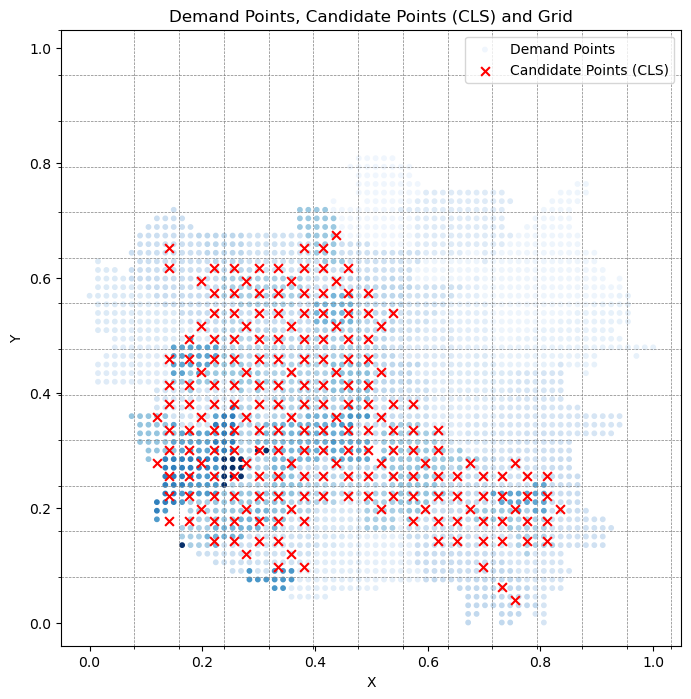

In [24]:
np.random.seed(2025)

r = 3000 * meter_norm
n = 200  
p = 30

## GBH ####################################################################
shift_ratio = 0.4 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * r

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_pts, r, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_pts, unique_candidate_points, r, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
cls = remove_least_effective_candidates_with_discount_and_demand(demand_pts, demand_vals, filtered_candidate_points, r, n)
print(f"Final number of CLS: {len(cls)}")

plot_points_demands_with_grid(demand_pts, demand_vals, cls, grid_size)

In [31]:
n_users = len(demand_pts)
n_facilities = n

dataset = MCLP.make_dataset(None, n_users, n_facilities, 1, 0, p, r, None)
dataset.data[0]['users'] = torch.FloatTensor(demand_pts)
dataset.data[0]['demand'] = torch.FloatTensor(demand_vals)
dataset.data[0]['facilities'] = torch.FloatTensor(cls)

dataloader = DataLoader(dataset, batch_size=1)

# get the first batch
batch = next(iter(dataloader))
batch = move_to(batch, device)

model_path = '../outputs/MCLP/hou_test_2465_200_30_20241013T080145/epoch-123.pt'  # Adjust this path to your saved model\n",
model, opts = load_model(model_path)  # load_model returns the model and options used during training\n",

  [*] Loading model from ../outputs/MCLP/hou_test_2465_200_30_20241013T080145/epoch-123.pt


In [36]:
start = time.time()
results = []

num_sample = 1
opts['eval_batch_size'] = 1
opts['max_calc_batch_size'] = 1280000

model.to(device)  # Move the model to the device (GPU/CPU)
model.eval()  # Set the model to evaluation mode
model.set_decode_type("sampling")
opts['decode_strategy'] = 'sampling'
width = 1280 if opts['decode_strategy'] == 'sampling' else 0

with torch.no_grad():
    if opts['decode_strategy'] in ('sampling', 'greedy'):
        if opts['decode_strategy'] == 'greedy':
            assert width == 0, "Do not set width when using greedy"
            assert opts["eval_batch_size"] <= opts["max_calc_batch_size"], \
                "eval_batch_size should be smaller than calc batch size"
            batch_rep = 1
            iter_rep = 1
        elif width * opts["eval_batch_size"] > opts["max_calc_batch_size"]:
            assert opts["eval_batch_size"] == 1
            assert width % opts["max_calc_batch_size"] == 0
            batch_rep = opts["max_calc_batch_size"]
            iter_rep = width // opts["max_calc_batch_size"]
        else:
            batch_rep = width
            iter_rep = 1
        assert batch_rep > 0
        
        # sampling
        sequences, costs = model.sample_many(batch, batch_rep=batch_rep, iter_rep=iter_rep)
        batch_size = len(costs)
        ids = torch.arange(batch_size, dtype=torch.int64, device=costs.device)

        if sequences is None:
            sequences = [None] * batch_size
            costs = [math.inf] * batch_size
        else:
            sequences, costs = get_best(
                sequences.cpu().numpy(), costs.cpu().numpy(),
                ids.cpu().numpy() if ids is not None else None,
                batch_size
            )
        duration = time.time() - start
        for seq, cost in zip(sequences, costs):
            seq = seq.tolist()
            results.append((cost, seq, duration))
            
# output
costs, tours, durations = zip(*results)
print(f"The objective is: {-costs[0]}")
print(tours[0])
end = time.time() - start
print(f"The running time of DRL is: {end}")

The objective is: 3277.517578125
[185, 162, 2, 39, 110, 84, 186, 150, 188, 25, 184, 194, 197, 195, 196, 191, 156, 114, 90, 12, 38, 94, 37, 125, 120, 72, 88, 177, 57, 73]
The running time of DRL is: 0.12194252014160156


Number of covered demand points: 810
3277.517512471044
The population covered is: 0.4251701926273756


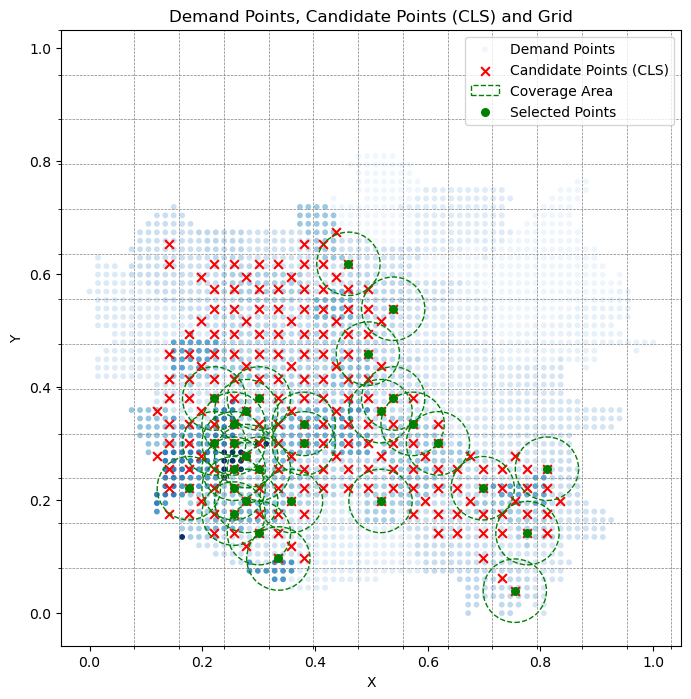

In [37]:
obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, tours[0])
print(obj_val)

ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points_vals_cov_with_grid(demand_pts, demand_vals, cls, grid_size, tours[0], r)

In [38]:
selected_facilities = select_and_reverse_normalize(cls, tours[0], S, x_min, y_min)
selected_facilities

file_name = "../data/deepgridmclp_result_points_3k_30.csv"
save_to_csv(selected_facilities, file_name)

## GA 200 - 30 - 3k

Current top solution: [125, 56, 152, 68, 185, 101, 11, 120, 78, 145, 73, 60, 28, 12, 0, 155, 111, 18, 164, 188, 199, 76, 55, 9, 8, 156, 171, 161, 122, 37] f=3857

Final top solution: [167, 114, 23, 150, 169, 3, 184, 161, 170, 78, 72, 66, 50, 56, 110, 25, 22, 155, 137, 127, 7, 34, 21, 196, 128, 93, 180, 189, 57, 111] f=3092
Time: 00:00:1.2424
Number of covered demand points: 1163
4615.886937159934
The population covered is: 0.598787811430745


C:\Users\yzhon\AppData\Local\Temp\ipykernel_76044\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


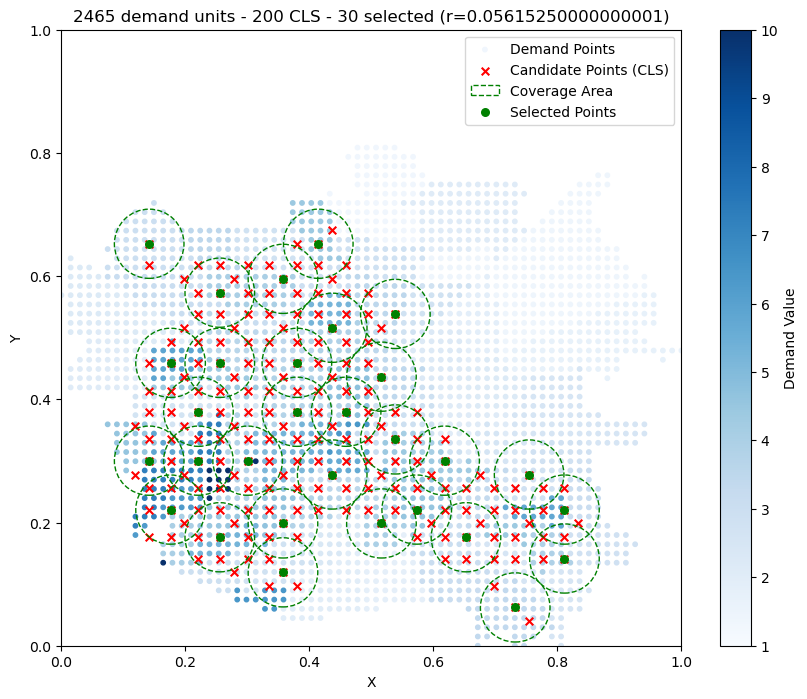

In [43]:
from algorithms.GA import GeneticAlgorithm

# Calculate the distance matrix (Euclidean distance between facilities and demand points)
distance = np.sqrt(np.sum((cls[:, np.newaxis, :] - demand_pts[np.newaxis, :, :]) ** 2, axis=-1))

# Instantiate the genetic algorithm with the necessary parameters
genetic = GeneticAlgorithm(len(demand_pts), len(cls), p, distance, r, demand_vals)

# Run the optimization process
genetic.optimize()

# Get the result (selected centers and the objective value)
obj = np.sum(demand_vals) - genetic.top_chromosome.fitness.item()  # Ensure fitness is a scalar
ga_solution = genetic.top_chromosome.content

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, ga_solution)
print(obj_val)
ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points(demand_pts, demand_vals, cls, ga_solution, r)

In [275]:
ga_selected_facilities = select_and_reverse_normalize(cls, ga_solution, S, x_min, y_min)

ga_file_name = "../data/ga_result_points_3k_30_4449.csv"
save_to_csv(ga_selected_facilities, ga_file_name)

## Greedy Select 200 - 30 - 3k

The running time of Greedy Select is: 0.0489044189453125
Greedy solution centers: [199, 185, 186, 164, 163, 161, 165, 156, 152, 159, 112, 113, 79, 66, 73, 30, 25, 174, 18, 20, 11, 22, 46, 118, 38, 23, 145, 179, 2, 98]
Objective value for greedy solution: 4800.4701522692685


C:\Users\yzhon\AppData\Local\Temp\ipykernel_76044\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


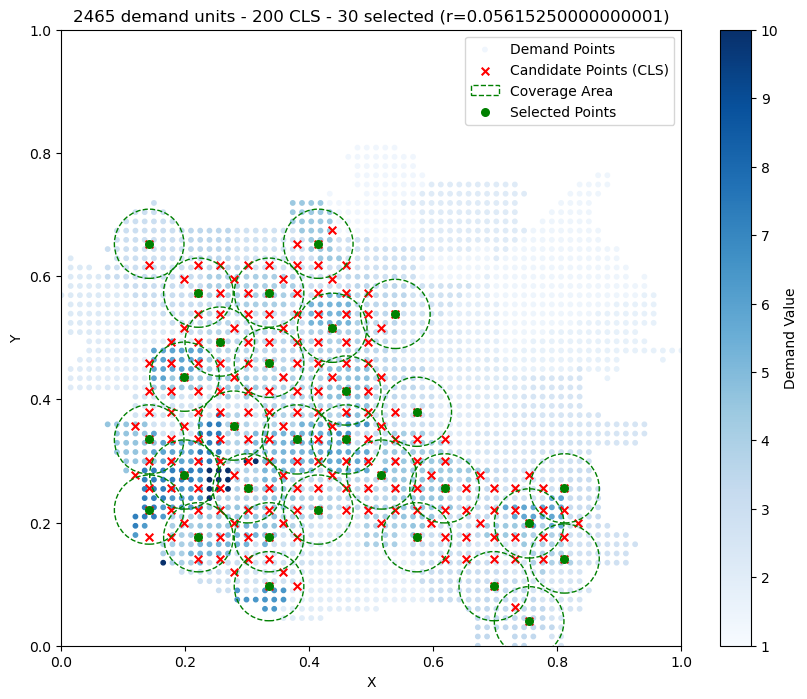

In [26]:
start = time.time()
greedy_solution, greedy_obj_val = greedy_select(demand_pts, demand_vals, cls, r, p)
end = time.time() - start
print(f"The running time of Greedy Select is: {end}")
print(f"Greedy solution centers: {greedy_solution}")
print(f"Objective value for greedy solution: {greedy_obj_val}")

# Optionally plot or compare results with the genetic algorithm solution
plot_points(demand_pts, demand_vals, cls, greedy_solution, r)

## CPlex 200 - 30 - 3k

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.08 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1425 rows and 861 columns.
Aggregator did 32 substitutions.
Reduced MIP has 1009 rows, 1208 columns, and 7803 nonzeros.
Reduced MIP has 1208 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (8.88 ticks)
Probing time = 0.01 sec. (0.43 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1009 rows, 1208 columns, and 7803 nonzeros.
Reduced MIP has 1208 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (5.84 ticks)
Probing time = 0.00 sec. (0.43 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.08 sec. (118.24 ticks)

        Nodes                                         Cuts/
   N

C:\Users\yzhon\AppData\Local\Temp\ipykernel_76044\1820494479.py:203: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Demand Value')


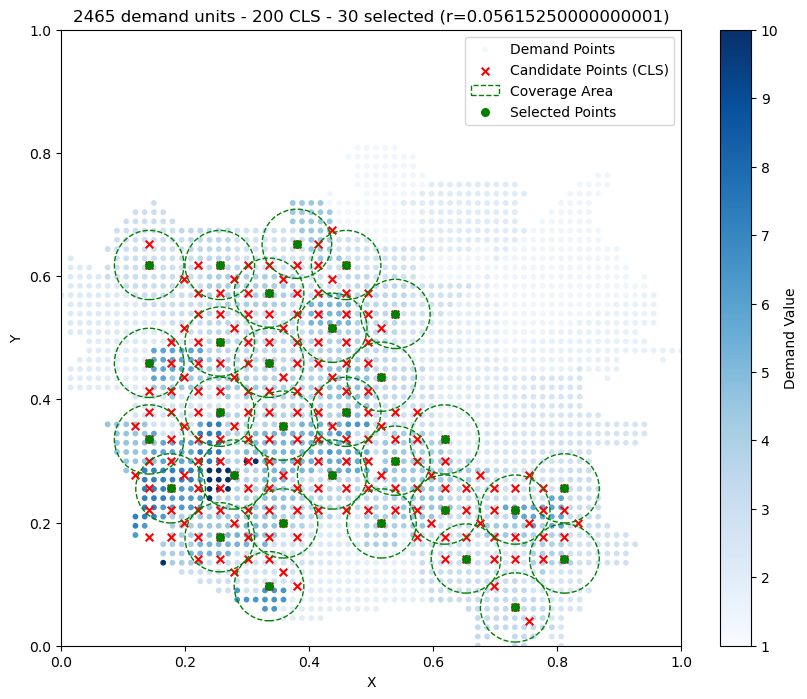

In [42]:
# Solve the problem using the genetic algorithm
cplex_solution = solve_mclp_cplex(demand_pts, demand_vals, cls, r, p)

obj_val = calculate_solution_objective(demand_pts, demand_vals, cls, r, cplex_solution)
print(obj_val)

ratio_covered = calculate_covered_ratio(obj_val, demand_vals)
print(f"The population covered is: {ratio_covered}")

plot_points(demand_pts, demand_vals, cls, cplex_solution, r)

In [272]:
cplex_selected_facilities = select_and_reverse_normalize(cls, cplex_solution, S, x_min, y_min)

cplex_file_name = "../data/cplex_result_points_3k_30.csv"
save_to_csv(cplex_selected_facilities, cplex_file_name)